In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
from util import *
from PatchGan import *
from dataset import *
torch.manual_seed(0)

In [2]:
adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
classfier_criterion = nn.CrossEntropyLoss()

n_epochs = 10 # number of epochs
in_chan = 1 # input channels
real_chan = 2# output channels, should be 3 if use rgb, be 2 if use lab
display_step = 1000 # step to display loss and colorized images
batch_size = 16
lr = 0.0002 # learning rate
shape = 128 # shape of input image of our model
classes = 365 # number of classes for our classfier
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pretrained = False # whether to use pretrained ckpt
ckpt_root = "./checkpoint/" # directory to load and save ckpt

In [3]:
train_set = Places365((shape, shape), mode = 'lab')

dataloader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True)

In [4]:
gen = UNet_Classfier(in_chan, real_chan, classes).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(in_chan + real_chan, real_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

curr_epoch = 0
if pretrained:
    loaded_state = torch.load(ckpt_root + "UNet_Gan_v4_" + str(curr_epoch) + ".pth", 
                             map_location = device)
    gen.load_state_dict(loaded_state["gen"])
    gen_opt.load_state_dict(loaded_state["gen_opt"])
    disc.load_state_dict(loaded_state["disc"])
    disc_opt.load_state_dict(loaded_state["disc_opt"])
    
else:    
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

In [5]:
# returns the feature from classfier, the loss for classfier, 
# and the loss for generator in GAN
def get_gen_loss(gen, disc, ab, l, target, 
                 adv_criterion, recon_criterion, classfier_criterion, lambda_recon):
    # Parameters:
    # gen: the generator; takes the gray img and returns generated colorful img,
    # as well as classfication
    # disc: the discriminator; takes real imgs and the gray imgs and
    # returns real/fake prediction matrices
    # real: the colorful imgs to be used to evaluate the reconstruction
    # gray: the gray imgs which are used to produce the colorful imgs 
    # adv_criterion: the usual gan loss function; takes the discriminator 
    # predictions and the true labels
    # recon_criterion: the reconstruction loss function; takes the generator 
    # outputs and the real images
    # lambda_recon: the degree to which the reconstruction loss should be weighted in the sum
    classes, gen_ab = gen(l)
    classfier_loss = classfier_criterion(classes, target)
    prediction_matrix = disc(l, ab)
    adv_loss = adv_criterion(prediction_matrix.detach(), torch.ones_like(prediction_matrix))
    recon_loss = recon_criterion(gen_ab, ab)
    gen_loss = adv_loss + lambda_recon*recon_loss + classfier_loss
    return gen_ab, gen_loss, classfier_loss

Pretrained initial state
real: 


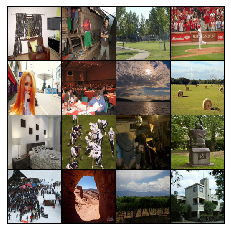

predict: 


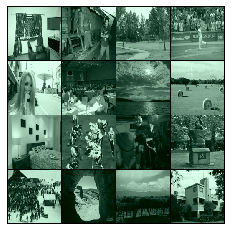

In [ ]:
from skimage import color
import numpy as np

def train(save_model=False):
    mean_generator_loss = 0
    mean_classfier_loss = 0
    mean_discriminator_loss = 0
    cur_step = 0
    lambda_recon = 200

    for epoch in range(curr_epoch+1, n_epochs):
        # Dataloader returns the batches        
        for data in tqdm(dataloader):
            ab, l, target = data
            cur_batch_size = len(l)
            l = l.to(device).float()
            ab = ab.to(device).float()
            target = target.to(device)

            ### Update discriminator ###
            disc_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                _, gen_ab = gen(l)
            disc_fake_hat = disc(l, gen_ab.detach()) # Detach generator
            disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
            disc_real_hat = disc(l, ab)
            disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True) # Update gradients
            disc_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_ab, gen_loss, classfier_loss = get_gen_loss(gen, disc, ab, l, target, adv_criterion,
                                                        recon_criterion, classfier_criterion, lambda_recon)
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step
            mean_classfier_loss += classfier_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss},\
                    Discriminator loss: {mean_discriminator_loss}, Classfier loss: {mean_classfier_loss}")
                else:
                    print("Pretrained initial state")
                print('real: ')
                show_tensor_lab(torch.cat([l, ab], dim=1), num_images = batch_size,size=(real_chan+1, shape, shape))
                print('predict: ')
                show_tensor_lab(torch.cat([l,gen_ab], dim=1), 
                                num_images = batch_size,size=(real_chan+1, shape, shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                mean_classfier_loss = 0
            cur_step += 1
        if save_model:
            torch.save({'gen': gen.state_dict(),
                'gen_opt': gen_opt.state_dict(),
                'disc': disc.state_dict(),
                'disc_opt': disc_opt.state_dict(),
            }, ckpt_root + "UNet_Gan_v4_" + str(curr_epoch) + ".pth")
            lambda_recon = lambda_recon - 40 if lambda_recon > 0 else 1
            
            
train(True)